### Configuration Variables

In [171]:
currentSeason = "2016-17"   # The current academic year. Can replace with python datettime

## Begin Code

In [196]:
# Assumes Anaconda Distribution

# For data manipulation
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
PROJ_ROOT = os.pardir

# For Scraping
from bs4 import BeautifulSoup
import requests
import time

# For munging
import re
import json

# Backoff time for large scrapes
THROTTLE_TIME = .05

# ipython magics
%load_ext watermark
%matplotlib inline
# a nice bonus for making progress bars in ipython
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
tqdm.pandas()

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark



In [3]:
%watermark -a "Cameron Yick" -d -t -v -p pandas,seaborn,matplotlib,bs4 -g

Cameron Yick 2016-10-22 15:58:48 

CPython 2.7.12
IPython 4.0.1

pandas 0.17.1
seaborn 0.7.1
matplotlib 1.5.0
bs4 4.4.1
Git hash: 6c89327aaea7699d7ffce4cb9b58f6ce5fd43d1f


In [31]:
root_url = "http://www.yalebulldogs.com"

In [69]:
# Core functions related to data scraping
# Kept here for readability, eventually move to 'src' folder

def getBodySoup(link):
    'Given URL Returns BS4 Object for link, feat. HTML body'
#     print("."),
    time.sleep(THROTTLE_TIME)
    site_url = link
    result = requests.get(site_url)
    if result.status_code is 200:
        return BeautifulSoup(result.content, 'lxml').find('body')
    else:
        print "Site is down!"
        return None

In [43]:
# Custom functions for this website
def getAllSports(soup):
    # Visit website, note that the sports are stored in 3 submenus
    # These are submenus of index 1, 2 4, and 5, but this is potentially subject to change.
    menus = soup.find_all(class_="submenu")
    sportMenus = [1, 2, 4, 5]
    sports = [] # array of sports objects
    
    for iMenu in sportMenus:
        for link in menus[iMenu].find_all('a'):
            sport = {}
            sport['name'] = link.text.strip()
            sport['href'] = root_url + link['href']
            sports.append(sport)
            
    return sports
            

## Get Each Sports Page from Homepage

In [129]:
# Verify that we get all the sports
homeSoup = getBodySoup(root_url)


In [130]:
sports = getAllSports(homeSoup)
print len(sports)

34


In [131]:
# Let's make a proper data structure
sports = pd.DataFrame(sports)

In [132]:
# pull the index term off the homepage
cleanIndex = re.compile("(.*)\/index")
sports['href'] = sports['href'].apply(lambda x: cleanIndex.search(x).group(1))

In [134]:
# just one sport is listed twice.
sports[sports['href'].duplicated()]

,href,name
25,http://www.yalebulldogs.com/sports/c-sail,Sailing (Coed)


In [136]:
sports = sports[sports['href'].duplicated() == False]

In [137]:
sports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 33
Data columns (total 2 columns):
href    33 non-null object
name    33 non-null object
dtypes: object(2)
memory usage: 792.0+ bytes


In [138]:
sports.head()


,href,name
0,http://www.yalebulldogs.com/sports/m-basebl,Baseball
1,http://www.yalebulldogs.com/sports/m-baskbl,Basketball
2,http://www.yalebulldogs.com/sports/m-crewhvy,Crew (Heavyweight)
3,http://www.yalebulldogs.com/sports/m-crewlt,Crew (Lightweight)
4,http://www.yalebulldogs.com/sports/m-xc,Cross Country


In [139]:
# Extract the genders for each sport: m / f / coed
getGender = re.compile("\/sports\/([mcw])-")
def getSportGender(url):
    return getGender.search(url).group(1)

In [140]:
sports['gender'] = sports['href'].map(getSportGender)

In [141]:
# Sanity check on # of genders per sport- . Only 1 coed sport shares a webpage
# One could give the other coed sports (Swim, track, basketball) coed designation, although
# having both genders on 1 team is unique to sailing.
sports.groupby('gender').count()

,href,name
gender,,
c,1,1
m,15,15
w,17,17


## Get the Seasons for which we have data for each sport

Below is some scratch code while the main functions are tested

In [56]:
test = sports['href'].iloc[1]

In [58]:
teamsoup = getBodySoup(test)

.


In [142]:
getSeason = re.compile("([\d\-]*)\/roster")
hasRoster = re.compile('Roster')
def currentSeason(team_url):
    teamsoup = getBodySoup(team_url)
    link = teamsoup.find('a', text=hasRoster)
    return getSeason.search(link['href']).group(1) 

In [143]:
# Check what the most current roster listing for the sport is.
sports['currentRoster'] = sports['href'].progress_apply(lambda x: currentSeason(x))

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:06<00:00,  2.08s/it]


In [91]:
# observe a data quality issue: sometiems the website link hasn't been updated even though the underlying page does 
# exist (ie in case of baseball.)
# However, in case of heavyweight crew, the new roster just isn't up yet.
sports.head(8)

,href,name,gender,currentRoster
0,http://www.yalebulldogs.com/sports/m-basebl/index,Baseball,m,2015-16
1,http://www.yalebulldogs.com/sports/m-baskbl/index,Basketball,m,2016-17
2,http://www.yalebulldogs.com/sports/m-crewhvy/i...,Crew (Heavyweight),m,2015-16
3,http://www.yalebulldogs.com/sports/m-crewlt/index,Crew (Lightweight),m,2016-17
4,http://www.yalebulldogs.com/sports/m-xc/index,Cross Country,m,2016-17
5,http://www.yalebulldogs.com/sports/m-fenc/index,Fencing,m,2016-17
6,http://www.yalebulldogs.com/sports/m-footbl/index,Football,m,2016-17
7,http://www.yalebulldogs.com/sports/m-golf/index,Golf,m,2016-17


In [182]:
# You'll have to check every year to see who's behind
# In this case, it's baseball and men's heavyweight crew
sports['currentRoster'].value_counts()

2016-17    31
2015-16     2
Name: currentRoster, dtype: int64

In [184]:
# In the case of baseball only, force their roster to advance by 1.
print sports.iloc[0]['name']
sports.iloc[0]['currentRoster'] = "2016-17"

Baseball


In [185]:
sports['currentRoster'].value_counts()

2016-17    32
2015-16     1
Name: currentRoster, dtype: int64

We can now have a `2016-2017` roster for every sport except men's heavyweight crew, since it seems the website has not been updated yet.

## Getting Rosters from Every Season


In [211]:
string = "fish"
print string[-2:]

sh


In [222]:
def prevSeason(season):
    'Given a season, return the previous one.'
    '2015-16 becomes 2014-15'
    years = season.split("-")
    prevYear = int(years[0]) - 1
    return "{0}-{1}".format(prevYear, years[0][2:])


def getSeasons(team_url, current_season):
    'given current season, check how many seasons back of rosters we can collect.'
    ' If refactoring, might as well save the rosters too.'

    print("\nDownload " + team_url)
    hasRoster = 1
    season = current_season
    seasons = {}

    while (hasRoster):
        print(season[-2:]),
        season_url = "{0}/{1}/roster".format(team_url, season)
        tsoup = getBodySoup(season_url)
        if not tsoup:
            break
        table = tsoup.find('table')
        if not table:
            break
        rows = table.find_all('tr')
        if not rows:
            break
        # different pages handled errors differently. ex:
        # swimming: template not found: http://www.yalebulldogs.com/sports/w-swim/2008-09/roster
        # coed sailing: loads a blank table: http://www.yalebulldogs.com/sports/c-sail/2004-05/roster
        # invoke the no 1-person team rule- if the roster table only has 2 or fewer rows in it, it's probably not 
        #         ok.
        if len(rows) < 3:
            break
        else:
            # Getting the rosters!
            people = []
            for row in rows:
                person = []
                for cell in row.find_all('td'):
                    bio_link = cell.find('a')
                    cellText = cell.text.strip()
                    
                    if bio_link:
                        
                        nameCard = {
                            'name': cellText,
                            'link': bio_link['href']
                        }
                        
                        person.append(nameCard)
                    else:
                        person.append(cellText)
                people.append(person)
                
            seasons[season] = people
            season = prevSeason(season)
            
        
    return seasons
        

In [217]:
sports.shape

(33, 6)

In [223]:
%%time
# Download the rosters for each sport
# Parallelize another time, split into separate variable due to some odd memory bug.
rosters = sports[['href', 'currentRoster']].apply(lambda x: getSeasons(x['href'], x['currentRoster']), axis='columns')


Download http://www.yalebulldogs.com/sports/m-basebl
17 16 15 14 13 12 11 10 09 08 
Download http://www.yalebulldogs.com/sports/m-baskbl
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 Site is down!

Download http://www.yalebulldogs.com/sports/m-crewhvy
16 15 14 13 12 11 10 09 08 
Download http://www.yalebulldogs.com/sports/m-crewlt
17 16 15 14 13 12 11 10 09 
Download http://www.yalebulldogs.com/sports/m-xc
17 16 15 14 13 12 11 10 09 
Download http://www.yalebulldogs.com/sports/m-fenc
17 16 15 14 13 12 11 10 09 08 
Download http://www.yalebulldogs.com/sports/m-footbl
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 Site is down!

Download http://www.yalebulldogs.com/sports/m-golf
17 16 15 14 13 12 11 10 09 08 07 06 05 04 03 Site is down!

Download http://www.yalebulldogs.com/sports/m-hockey
17 16 15 14 13 12 11 10 09 
Download http://www.yalebulldogs.com/sports/m-lacros
17 16 15 14 13 12 11 10 09 
Download http://www.yalebulldogs.com/sports/c-sail
17 16 15 14 13 12 11 10 09 08 
Download htt

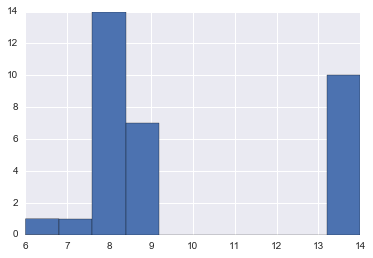

In [235]:
# Everybody has at least 6 years of data. There are a few sports with 14 years of data. 
# I wonder what made a team join?
# We can do facet plots of how the size of a team's roster changed from year to year.
# Alternately, we can build a list of what high schools people come from...
rosters.map(len).hist()

In [226]:
sports['nSeasons'] = rosters.map(len)

In [228]:
sports['rosters'] = rosters

In [230]:
# check what the number of people in a season looks like
sports.iloc[0]['rosters'][currentSeason]

[[{'link': '/sports/m-basebl/2016-17/roster?sort=number', 'name': u'No.'},
  {'link': '/sports/m-basebl/2016-17/roster?sort=last_name', 'name': u'Name'},
  {'link': '/sports/m-basebl/2016-17/roster?sort=position', 'name': u'Pos.'},
  {'link': '/sports/m-basebl/2016-17/roster?sort=year', 'name': u'Cl.'},
  u'B/T',
  u'Ht.',
  u'Wt.',
  u'Hometown/High School'],
 [u'',
  u'1',
  {'link': '/sports/m-basebl/2016-17/bios/whiteman_simon_p54m',
   'name': u'Simon Whiteman'},
  u'IF/OF',
  u'So.',
  u'R/R',
  u'5-10',
  u'170',
  u'Trumbull, Conn. / Fairfield Prep'],
 [u'',
  u'2',
  {'link': '/sports/m-basebl/2016-17/bios/degraw_tim_6meu',
   'name': u'Tim DeGraw'},
  u'OF',
  u'So.',
  u'R/R',
  u'5-10',
  u'170',
  u'Rye, N.Y. / Rye High School'],
 [u'',
  u'3',
  {'link': '/sports/m-basebl/2016-17/bios/fuller_tom_ye5u',
   'name': u'Tom Fuller'},
  u'C',
  u'So.',
  u'R/R',
  u'5-11',
  u'170',
  u'Santa Monica, Calif. / Harvard Westlake'],
 [u'',
  u'5',
  {'link': '/sports/m-basebl/2016-

In [231]:
sports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 33
Data columns (total 7 columns):
href             33 non-null object
name             33 non-null object
gender           33 non-null object
currentRoster    33 non-null object
seasons          33 non-null object
nSeasons         33 non-null int64
rosters          33 non-null object
dtypes: int64(1), object(6)
memory usage: 2.1+ KB


In [238]:
type(sports.iloc[0]['rosters'][currentSeason])

list

In [249]:
# dump as pickle too so objects don't get turned into strings
EXPORT_PICKLE = os.path.join(PROJ_ROOT, "data", "raw", "sports.p")
sports.to_pickle(EXPORT_PICKLE)

In [250]:
# Dump the file!
EXPORT_PATH = os.path.join(PROJ_ROOT, "data", "raw", "sports.json")
sports.to_json(EXPORT_PATH)